In [1]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import copy
import cv2

In [2]:
points = sk.io.imread('./binning/s3 10x_2021_02_17__14_54_50.pro.tif_withtime.tif')

z = 278

coords = np.transpose(np.nonzero(points[z] != 0))

# Delaunay triangulation

In [3]:
from scipy.spatial import Delaunay

class MyDelaunay(Delaunay):
    def __init__(self, points):
        super().__init__(points)

    def triangle_area(self, simplex):
        p1, p2, p3 = self.points[simplex]
        return 0.5 * np.abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

    def calculate_triangle_areas(self):
        return [self.triangle_area(simplex) for simplex in self.simplices]

    def largest_triangle_angle(self):
        largest_angles = []

        for simplex in self.simplices:
            p1, p2, p3 = self.points[simplex]

            # Calculate vectors
            v1 = p2 - p1
            v2 = p3 - p1
            v3 = p3 - p2

            # Calculate angles
            angle1 = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angle2 = np.arccos(np.dot(-v1, v3) / (np.linalg.norm(v1) * np.linalg.norm(v3)))
            angle3 = np.pi - angle1 - angle2

            largest_angle = max(angle1, angle2, angle3)
            largest_angles.append(np.degrees(largest_angle))

        return largest_angles
    
    def largest_triangle_side(self):
        largest_sides = []
        
        for simplex in self.simplices:
            p1, p2, p3 = self.points[simplex]
            largest_side = max([np.sqrt((p1[0]-p1[1])**2+(p2[0]-p2[1])**2),
                                np.sqrt((p1[0]-p1[1])**2+(p3[0]-p3[1])**2),
                                np.sqrt((p2[0]-p2[1])**2+(p3[0]-p3[1])**2)])
            largest_sides.append(largest_side)
        
        return largest_sides


tri = MyDelaunay(coords)

Mean: 133.46,  Std: 849.57
Threshold at 133.46 + 849.57. Only cut above mean values.
Median: 30.00, Iqr: 30.00
3409 -> 2920


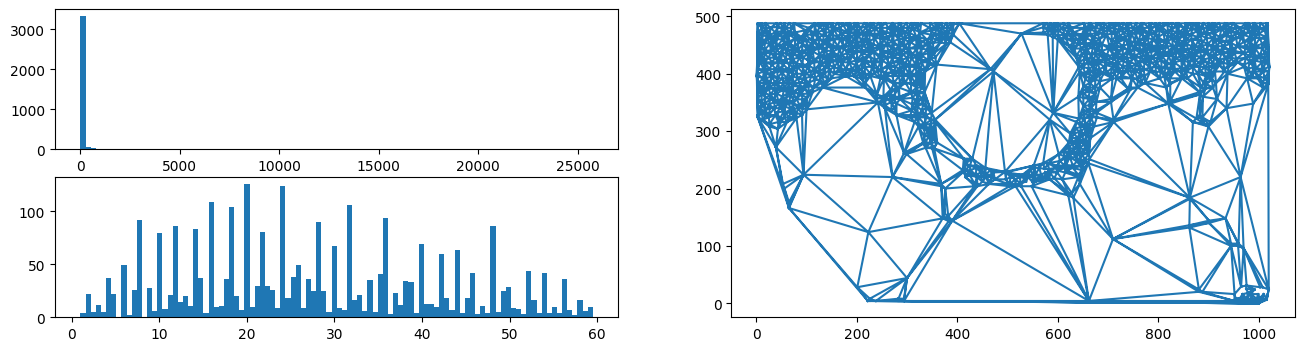

In [4]:
areas = np.array(tri.calculate_triangle_areas())

plt.figure(figsize=(16, 4))
plt.subplot(221)
plt.hist(areas, bins=100);
mean = areas.mean()
std = areas.std()
print(f'Mean: {mean:.2f},  Std: {std:.2f}')

plt.subplot(223)
threshold = 1
print(f'Threshold at {mean:.2f} + {threshold * std:.2f}. Only cut above mean values.')
median_value = np.median(areas)
iqr = np.percentile(areas, 75) - np.percentile(areas, 25)
print(f'Median: {median_value:.2f}, Iqr: {iqr:.2f}')

mask = (areas - median_value) < threshold * iqr
#mask = (areas - mean) < threshold * std
filtered_areas = areas[mask]
plt.hist(filtered_areas, bins=100);

masked_simplices = []
for simplex in tri.simplices:
    if np.any(mask[simplex]):
        masked_simplices.append(simplex)

masked_simplices = np.array(masked_simplices)
print(f'{len(masked_simplices)} -> {np.count_nonzero(mask)}')

plt.subplot(122)
plt.triplot(coords[:, 1], coords[:, 0], masked_simplices)
#plt.plot(points[:, 1], points[:, 0])
plt.show()

Mean of angles: 91.94, std of angles: 20.61
 3441 -> 3003


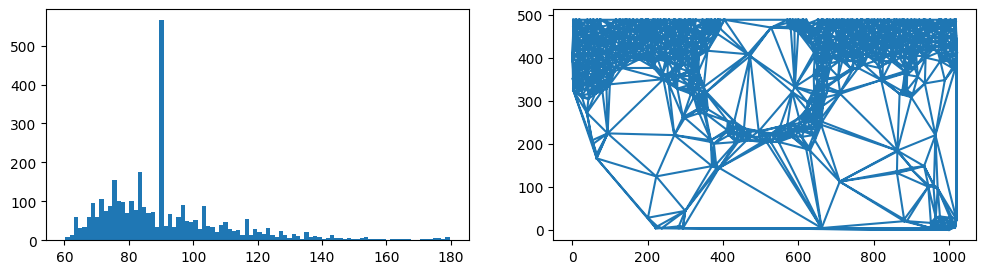

In [5]:
largest_angles = np.array(tri.largest_triangle_angle())
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist(largest_angles, bins=90);
angle_mean = largest_angles.mean()
angle_std = largest_angles.std()
print(f'Mean of angles: {angle_mean:.2f}, std of angles: {angle_std:.2f}')
threshold = 1
angle_mask = (largest_angles - angle_mean) < threshold * angle_std


masked_simplices = []
for simplex in tri.simplices:
    if np.any(angle_mask[simplex]):
        masked_simplices.append(simplex)

masked_simplices = np.array(masked_simplices)
print(f' {len(masked_simplices)} -> {np.count_nonzero(angle_mask)}')
plt.subplot(122)
plt.triplot(coords[:, 1], coords[:, 0], masked_simplices)
plt.show()

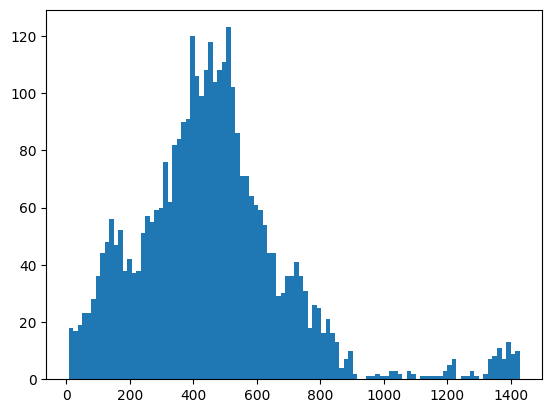

In [6]:
sides = tri.largest_triangle_side()
plt.hist(sides, bins=100);

From 3495 -> 1663


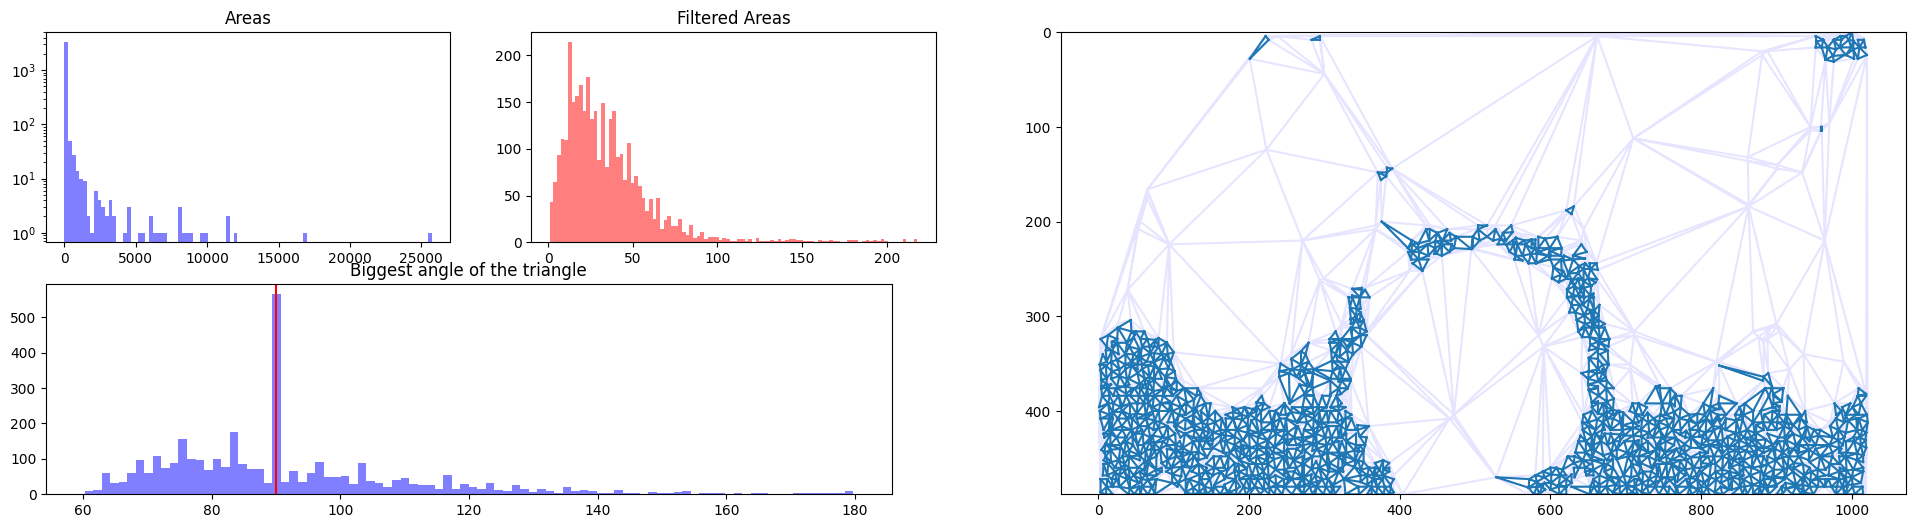

In [7]:
# Calculate triangle areas and largest angles
triangle_areas = np.array(tri.calculate_triangle_areas())
largest_angles = np.array(tri.largest_triangle_angle())

# Define thresholds for areas and angles
threshold_area = 0.1
threshold_angle = 90

# Create masks based on thresholds
mask_area = (triangle_areas - triangle_areas.mean()) < threshold_area * triangle_areas.std()
mask_angle = largest_angles < threshold_angle

# Combine masks using logical AND (you can also use | for OR)
combined_mask = mask_area & mask_angle

print(f'From {len(tri.simplices)} -> {np.count_nonzero(combined_mask)}')
filtered_simplices = tri.simplices[combined_mask]

plt.figure(figsize=(24,6))

plt.subplot(241)
plt.hist(triangle_areas, alpha=0.5, color='blue', bins=100, log=True)
plt.title('Areas')

plt.subplot(242)
plt.hist(triangle_areas[mask_area], alpha=0.5, color='red', bins=100)
plt.title('Filtered Areas')

plt.subplot(223)
plt.hist(largest_angles, alpha=0.5, color='blue', bins=90)
# plt.hist(largest_angles[mask_angle], alpha=0.5, color='red', bins=12)
plt.axvline(x=threshold_angle, color='red')
plt.title('Biggest angle of the triangle')

plt.subplot(122)
plt.triplot(coords[:, 1], coords[:, 0], tri.simplices, color='blue', alpha=0.1)
plt.triplot(coords[:, 1], coords[:, 0], filtered_simplices)
plt.ylim(max(coords[:, 0]), min(coords[:, 0]))
plt.show()

# Use the triangles to create a mask

Transform the lines into points and using all the points complete the spaces by filling if the area is less than a threshold? Or maybe put a point in the middle and then repeat this process until there is no more space to be filled.

In [8]:
def bresenham_line(x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy

    x, y = x1, y1

    while True:
        points.append((x, y))

        if x == x2 and y == y2:
            break

        e2 = 2 * error

        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points

(490, 1024)


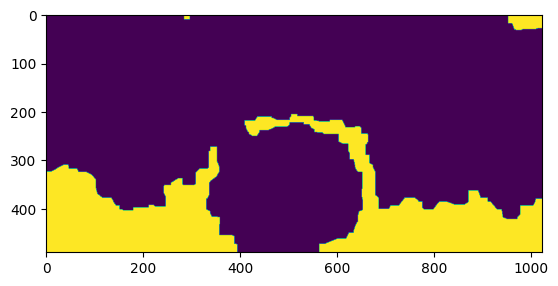

In [22]:
mask = np.zeros((points.shape[1], points.shape[2]))
print(mask.shape)

# Your existing loop
for i in filtered_simplices:

    to_1 = bresenham_line(*coords[i][0], *coords[i][1])
    to_1 += list(bresenham_line(*coords[i][1], *coords[i][2]))
    to_1 += list(bresenham_line(*coords[i][0], *coords[i][2]))
    
    
    for i in to_1:
        mask[i] = 1


mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((20, 20)))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((10, 10)))


plt.imshow(mask)




### Another approach to create a network out of the dots

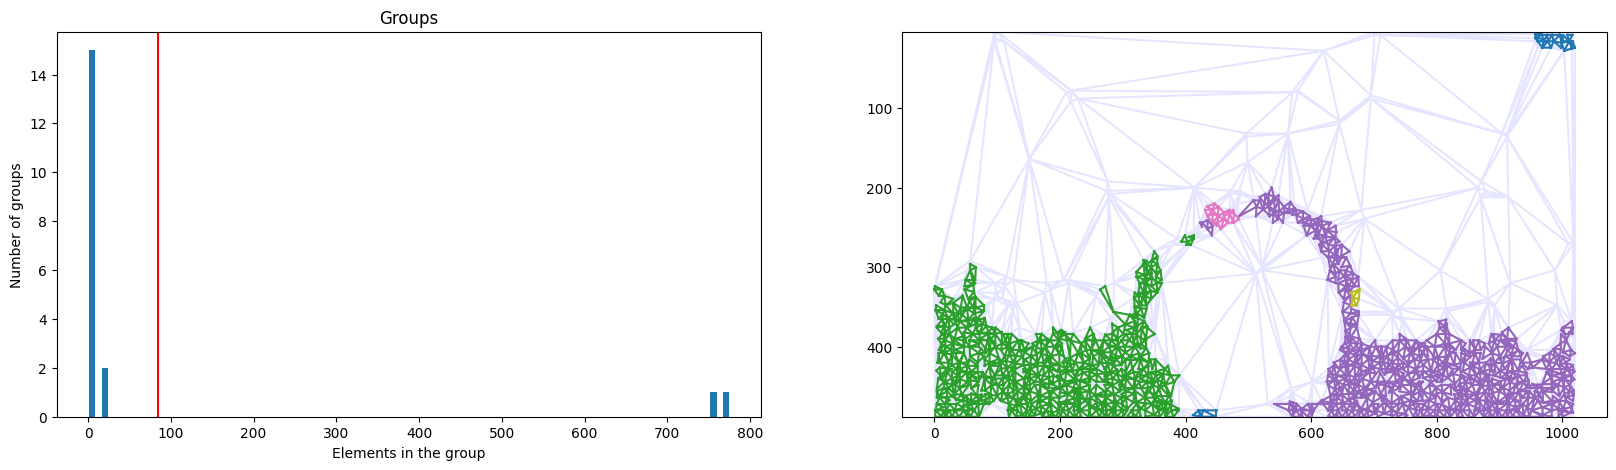

In [559]:
import networkx as nx
G = nx.Graph()
# Add edges from triangles
for triangle in filtered_simplices:
    G.add_edges_from([(triangle[0], triangle[1]), (triangle[1], triangle[2]), (triangle[0], triangle[2])])

# Find connected components (groups)
groups = list(nx.connected_components(G)) # List of sets


# # Print the groups
# for i, group in enumerate(groups, 1):
#     print(f"Group {i}: {group}")


temp_simplices = tri.simplices[list(groups[0])]
# print(coords[list(groups[0])])




groups_ids = []
for group in groups:
    my_set = set()
    for e in group:
        my_set.update(np.where(filtered_simplices == e)[0])
    groups_ids.append(my_set)



plt.figure(figsize=(20, 5))
plt.subplot(121)
lens = np.array([len(group) for group in groups_ids])
plt.hist(lens, bins=100)
lens_mean = lens.mean()
plt.axvline(x=lens_mean, color='r')
plt.title('Groups')
plt.ylabel('Number of groups')
plt.xlabel('Elements in the group')


plt.subplot(122)
plt.triplot(coords[:, 1], coords[:, 0], tri.simplices, color='blue', alpha=0.1)

for i, group in enumerate(groups_ids, 0):
    if len(group) >= 3: ## Be careful here!!! if len(group) >= lens_mean
        plt.triplot(coords[:, 1], coords[:, 0], filtered_simplices[list(groups_ids[i])])

plt.ylim(max(coords[:, 0]), min(coords[:, 0]))
plt.show()

# First dot idea

Remove alone dots until connections of k=5 < than a given number (for instance 10), and the find connections 

In [85]:
from scipy.spatial import KDTree


kdtree = KDTree(coords)

# Query the KDTree to find the 5 nearest neighbors for each dot
k_neighbors = 5
distances, indices = kdtree.query(coords, k=k_neighbors+1)  # k+1 to exclude the dot itself


In [86]:
for i, dot in enumerate(coords):
    print(f"Dot {i}: Nearest neighbors - {coords[indices[i][1:]]}, Distances - {distances[i][1:]}")

Dot 0: Nearest neighbors - [[   8  996]
 [   4  992]
 [   9 1002]
 [   8 1008]
 [   6 1012]], Distances - [ 8.94427191  8.94427191  9.21954446 11.3137085  13.41640786]
Dot 1: Nearest neighbors - [[  4 226]
 [  8 226]
 [  4 238]
 [ 28 201]
 [  4 283]], Distances - [ 4.          5.65685425 16.         31.89043744 61.        ]
Dot 2: Nearest neighbors - [[  4 222]
 [  8 226]
 [  4 238]
 [ 28 201]
 [  4 283]], Distances - [ 4.         4.        12.        34.6554469 57.       ]
Dot 3: Nearest neighbors - [[  4 226]
 [  8 226]
 [  4 222]
 [ 28 201]
 [  4 283]], Distances - [12.         12.64911064 16.         44.10215414 45.        ]
Dot 4: Nearest neighbors - [[  8 283]
 [  4 294]
 [  8 294]
 [ 44 300]
 [  4 238]], Distances - [ 4.         11.         11.70469991 43.46262762 45.        ]
Dot 5: Nearest neighbors - [[  8 294]
 [  4 283]
 [  8 283]
 [ 44 300]
 [  4 238]], Distances - [ 4.         11.         11.70469991 40.44749683 56.        ]
Dot 6: Nearest neighbors - [[112 710]
 [184 631

In [87]:
indices_to_remove = []
for i, dot in enumerate(coords):
    for distance in distances[i][1:]:
        if distance > 15:
            indices_to_remove.append(i)
            break

remove_coords = coords[indices_to_remove]

close_points = copy.copy(points[z])

for coord in remove_coords:

    close_points[coord[0], coord[1]] = 0


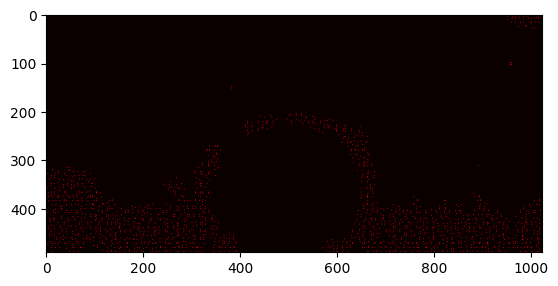

In [88]:
plt.imshow(close_points, cmap='hot')

In [108]:
clean_coords = np.transpose(np.nonzero(close_points != 0))

kdtree = KDTree(clean_coords)

# Query the KDTree to find the 5 nearest neighbors for each dot
k_neighbors = 5
distances, indices = kdtree.query(clean_coords, k=k_neighbors+1)  # k+1 to exclude the dot itself

In [109]:
all_dots = []
close_lines = copy.copy(close_points)

for i, dot in enumerate(clean_coords):
    # print(f"Dot {i}: Nearest neighbors - {coords[indices[i][1:]]}, Distances - {distances[i][1:]}")
    for c in clean_coords[indices][i][1:]:
        line_points = bresenham_line(*clean_coords[indices][i][0], *c)
        
        for l in line_points:
            close_lines[l] = 1

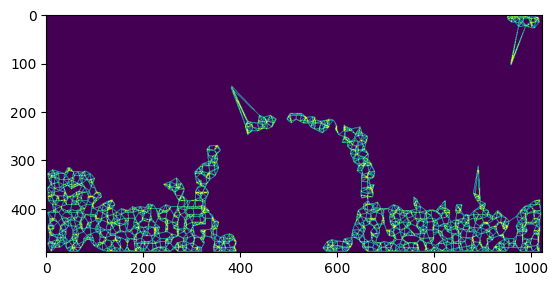

In [110]:
plt.imshow(close_lines)

In [100]:
def bresenham_line(x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy

    x, y = x1, y1

    while True:
        points.append((x, y))

        if x == x2 and y == y2:
            break

        e2 = 2 * error

        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points

# Example usage
point1 = [0, 12]
point2 = (5, 15)

line_points = bresenham_line(*point1, *point2)

# Print the coordinates of points along the line
for point in line_points:
    print(f"Point: {point}")

Point: (0, 12)
Point: (1, 13)
Point: (2, 13)
Point: (3, 14)
Point: (4, 14)
Point: (5, 15)
